# Tiling experiments

The 2D U-Net model was trained on the BraTS 2018 dataset to predict the whole tumor using the FLAIR channel of the raw MRI. We scaled the FLAIR channel by subtracting the mean value and dividing by the standard deviation. We then trained the model using a center-cropped patch of size 128x128 from the original 240x240 image. Only 2D slices were considered. Our final Dice metric was 0.84 on the test dataset.

This code shows the results of performing inference on overlapping tiles of the original image versus infering on the entire 240x240 image. Our results show that there are many false positive tumor predictions caused by the tiling method which can be mitigated (but not fully resolved) using a high degree of overlap and a large tile size. We conclude that using the full image size for inference is preferable to reduce the false positive rate.

In [7]:
import os

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # For GPU

import keras
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

In [2]:
def dice(msk, pred):
    """
    Dice coefficient
    """
    smooth = 1.0
    
    numerator = 2.0 * np.sum(msk*pred) + smooth
    denominator = np.sum(msk)+np.sum(pred) + smooth 
    
    
    return numerator/denominator

## Load the model

The model is a 2D U-Net (with batch norm) that was trained on a center-cropped patch of size 128x128 from the original FLAIR channel of the MRI. 

In [3]:
model = keras.models.load_model("model128x128/unet_model_upsampling_128x128.hdf5")

## Load the full size image and masks

In [4]:
data_path = "../../data/Brats2018/"

imgs128x128 = np.load(os.path.join(data_path, "128x128/imgs_test.npy"), mmap_mode="r", allow_pickle=False)
msks128x128 = np.sum(np.load(os.path.join(data_path, "128x128/msks_test.npy"), mmap_mode="r", allow_pickle=False), axis=-1)

imgs240x240 = np.load(os.path.join(data_path, "240x240/imgs_test.npy"), mmap_mode="r", allow_pickle=False)
msks240x240 = np.sum(np.load(os.path.join(data_path, "240x240/msks_test.npy"), mmap_mode="r", allow_pickle=False), axis=-1)


## Tiling algorithm

The original 240x240 image (2D slice) is broken into equally-sized, overlapping tiles. We perform inference on each tile and add its prediction to the combined mask prediction. The final combined prediction is scaled to account for the overlapping predictions.

In [8]:
def predict_tiles(slice_id, model, imgs):

    # 2371, 230, 6200, 5550, 791, 55, 1915, 1775, 987, 980, 1788
    # Counter? 1533, 1770, 730, 1368
    # 1372 is interesting case
    # 1527 and 1533 are exact counter examples from same scan

    """
    230 is very nice example where Dice doesn't tell the story.
    The Dice is better for the tiled, but the tiled prediction
    misses a separate tumor in the image (but whole image prediction)
    catches it.
    """
    maxx = imgs.shape[1]  # Width of whole image
    maxy = imgs.shape[2]  # Height of whole image
    patchx = 128  # Width of tile for inference (1 to maxx)
    patchy = 128  # Height of tile for inference (1 to maxy)
    stepx = 64  # How many pixels to slide in x direction (1 to patchx-1)
    stepy = 64  # How many pixels to slide in y direction (1 to patchy-1)

    idx = 0

    full_image = model.predict(np.expand_dims(imgs[slice_id:(slice_id+1),:,:,2], -1), verbose=0)

    combined = np.zeros((maxx,maxy))
    scaled = np.zeros((maxx,maxy))

    tile_counter = 0

    while (idx < maxx):

        idy = 0
        while (idy < maxy):

            tile_counter += 1

            if (idx < (maxx-patchx)):
                x = idx
            else:
                x = maxx - patchx
                idx = maxx

            if (idy < (maxy-patchy)):
                y = idy
            else:
                y = maxy - patchy
                idy = maxy

            p = model.predict(np.expand_dims(imgs[slice_id:(slice_id+1),x:(x+patchx),y:(y+patchy),2], -1), verbose=0)
            combined[x:(x+patchx),y:(y+patchy)] += p[0,:,:,0]

            # Scaled gives us a count of how many patches we have overlaid
            # This way we can divide by that number to get the average prediction
            # for that pixel.
            scaled[x:(x+patchx),y:(y+patchy)] += np.ones((patchx, patchy))

            idy += stepy

        idx += stepx
        
    combined /= scaled  # Divide to get the average prediction for the pixel
    
    threshold = combined.copy()
    threshold[threshold < 0.5] = 0.0  # Get rid of anything less than 0.5

    return combined, threshold, full_image, tile_counter


In [10]:
tiled_dice = np.zeros(imgs240x240.shape[0])
threshold_dice = np.zeros(imgs240x240.shape[0])
full_image_dice = np.zeros(imgs240x240.shape[0])

for idx in tqdm(range(imgs240x240.shape[0])):
    
    combined, threshold, full_image, tile_counter = predict_tiles(idx, model, imgs240x240)

    tiled_dice[idx] = dice(msks240x240[idx,:,:],combined)
    threshold_dice[idx] = dice(msks240x240[idx,:,:],threshold)
    full_image_dice[idx] = dice(msks240x240[idx,:,:],full_image[0,:,:,0])     


  1%|          | 66/6635 [02:12<3:39:11,  2.00s/it]

KeyboardInterrupt: 

Number of tile calculations = 9


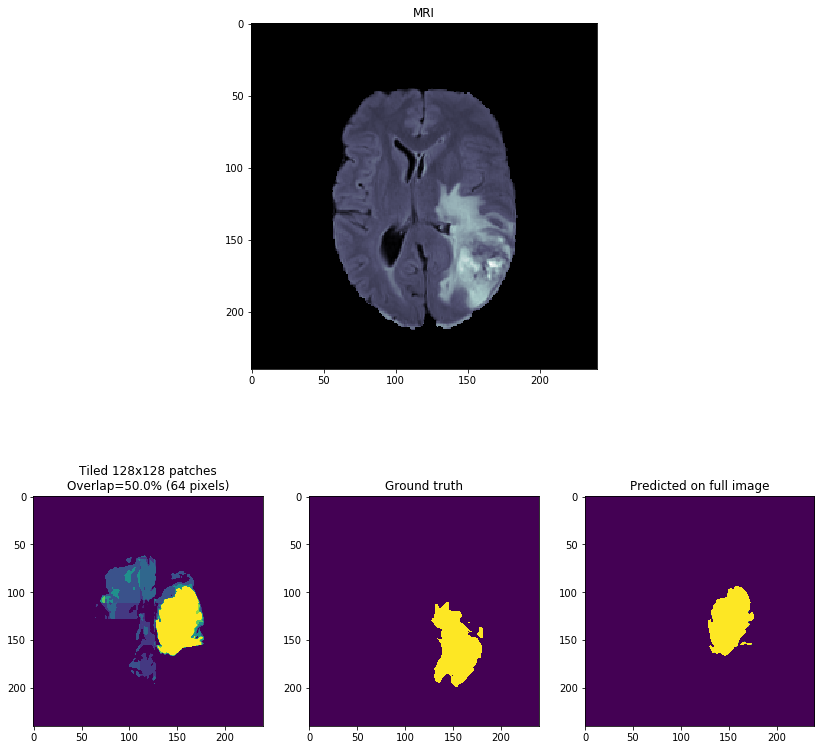

In [299]:
plt.figure(figsize=(14,14))
plt.subplot2grid((2, 3), (0, 0), colspan=3)
plt.imshow(imgs240x240[slice_id,:,:,2], cmap="bone");
plt.title("MRI");
plt.subplot2grid((2, 3), (1, 1));
plt.imshow(msks240x240[slice_id,:,:]);
plt.title("Ground truth");
plt.subplot2grid((2, 3), (1, 0));
plt.imshow(combined);
plt.title("Tiled {}x{} patches\nOverlap={:.1f}% ({} pixels)".format(patchx,
                                                                    patchy,
                                                                    (100.0-100.0*stepx/patchx),
                                                                    patchx-stepx));
plt.subplot2grid((2, 3), (1, 2));
plt.imshow(full_image[0,:,:,0]);
plt.title("Predicted on full image");

print("Number of tile calculations = {}".format(tile_counter))

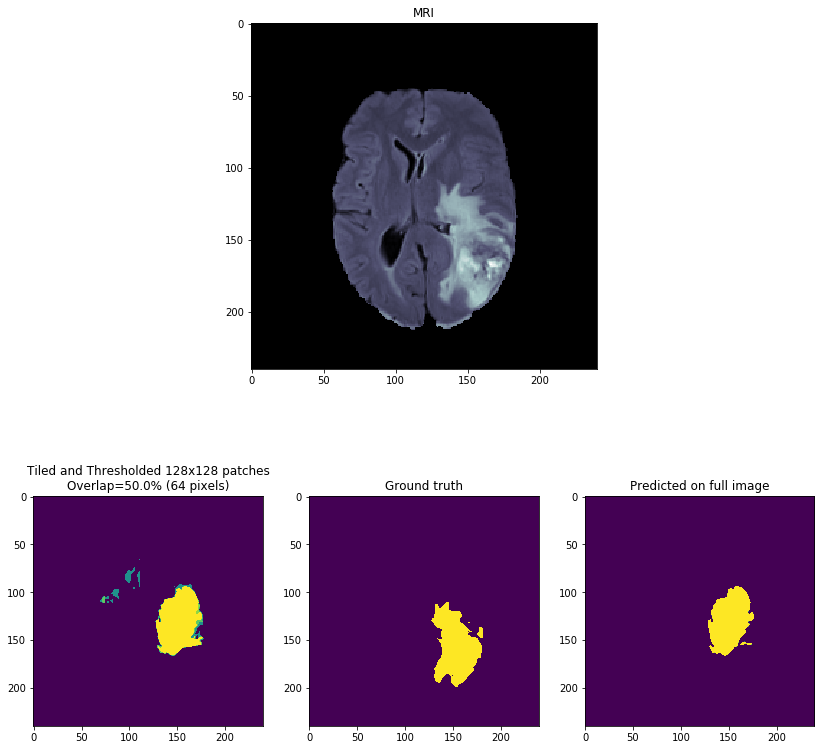

In [300]:
threshold = combined.copy()
threshold[threshold < 0.5] = 0.0  # Get rid of anything less than 0.5

plt.figure(figsize=(14,14))
plt.subplot2grid((2, 3), (0, 0), colspan=3)
plt.imshow(imgs240x240[slice_id,:,:,2], cmap="bone");
plt.title("MRI");
plt.subplot2grid((2, 3), (1, 1));
plt.imshow(msks240x240[slice_id,:,:]);
plt.title("Ground truth");
plt.subplot2grid((2, 3), (1, 0));
plt.imshow(threshold);
plt.title("Tiled and Thresholded {}x{} patches\nOverlap={:.1f}% ({} pixels)".format(patchx,
                                                                    patchy,
                                                                    (100.0-100.0*stepx/patchx),
                                                                    patchx - stepx));
plt.subplot2grid((2, 3), (1, 2));
plt.imshow(full_image[0,:,:,0]);
plt.title("Predicted on full image");



In [301]:
tiled_dice = dice(msks240x240[slice_id,:,:],combined)
threshold_dice = dice(msks240x240[slice_id,:,:],threshold)
full_image_dice = dice(msks240x240[slice_id,:,:],full_image[0,:,:,0])     

print("Tiled Dice = {:.4f}".format(tiled_dice))
print("Thresholded tiling Dice = {:.4f}".format(threshold_dice))
print("Full image Dice = {:.4f}".format(full_image_dice))

if (full_image_dice >= threshold_dice):
    print("Full is better or equal.")
else:
    print("Threshold tiled is better.")

Tiled Dice = 0.4316
Thresholded tiling Dice = 0.5010
Full image Dice = 0.4842
Threshold tiled is better.
